In [ ]:
!pip install lime tensorflow opencv-python matplotlib scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=829690648fc5de167b7cf8f4e90628979de16ca1547631d12de029e350c3b8ca
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from lime import lime_image
from skimage.segmentation import mark_boundaries
import cv2
import os


In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"riyamukkari","key":"52116a3d4abbb783bb4cc7db82eb7603"}'}

In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.27G/2.29G [00:32<00:00, 319MB/s]
100% 2.29G/2.29G [00:32<00:00, 75.7MB/s]


In [ ]:
!unzip -q chest-xray-pneumonia.zip -d /content/dataset
!ls -la /content/dataset


total 12
drwxr-xr-x 3 root root 4096 Oct 15 07:14 .
drwxr-xr-x 1 root root 4096 Oct 15 07:14 ..
drwxr-xr-x 7 root root 4096 Oct 15 07:14 chest_xray


In [ ]:
import os

base_dir = "/content/dataset/chest_xray"
for split in ["train", "val", "test"]:
    for cls in ["NORMAL", "PNEUMONIA"]:
        path = os.path.join(base_dir, split, cls)
        print(split, cls, ":", len(os.listdir(path)))


train NORMAL : 1341
train PNEUMONIA : 3875
val NORMAL : 8
val PNEUMONIA : 8
test NORMAL : 234
test PNEUMONIA : 390


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)


train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_gen = test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_gen, epochs=3, validation_data=test_gen)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 1244s 8s/step - accuracy: 0.7523 - loss: 0.5542 - val_accuracy: 0.6651 - val_loss: 0.5619
Epoch 2/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 1212s 7s/step - accuracy: 0.7753 - loss: 0.4541 - val_accuracy: 0.6939 - val_loss: 0.5369
Epoch 3/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 1209s 7s/step - accuracy: 0.7823 - loss: 0.4277 - val_accuracy: 0.7949 - val_loss: 0.4801


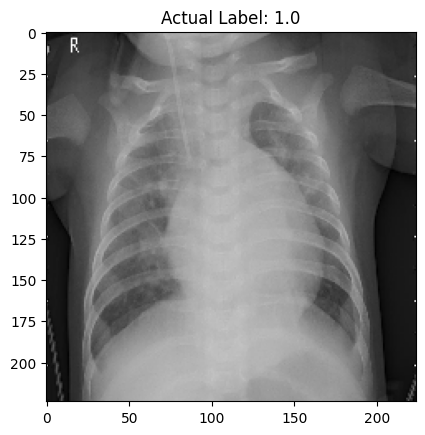

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediction (0=Normal, 1=Pneumonia): 0.8450


In [ ]:

sample_img, sample_label = next(test_gen)
img = sample_img[0]
plt.imshow(img)
plt.title(f"Actual Label: {sample_label[0]}")
plt.show()

pred = model.predict(np.expand_dims(img, axis=0))[0][0]
print(f"Prediction (0=Normal, 1=Pneumonia): {pred:.4f}")


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

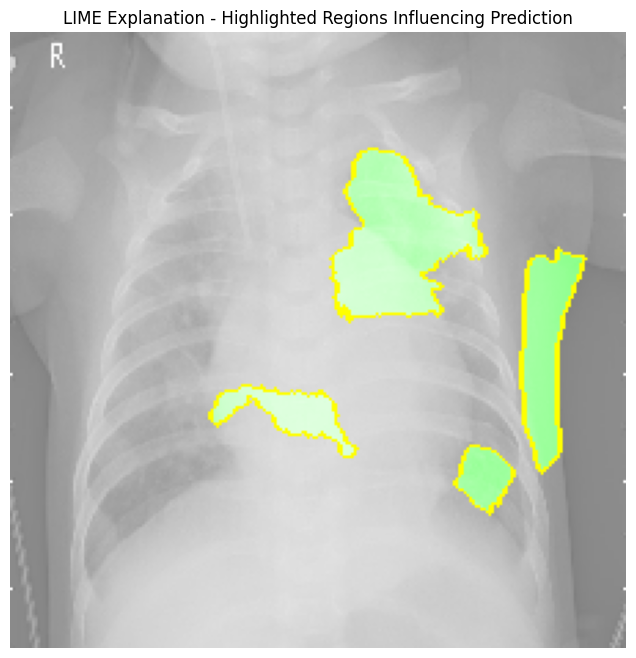

In [ ]:
  from lime import lime_image
  from skimage.segmentation import mark_boundaries
  import numpy as np
  import matplotlib.pyplot as plt


  def predict_fn(images):
      preds = model.predict(images)

      preds_2class = np.concatenate([1 - preds, preds], axis=1)
      return preds_2class


  explainer = lime_image.LimeImageExplainer()


  explanation = explainer.explain_instance(
      image=img.astype('double'),
      classifier_fn=predict_fn,
      top_labels=2,
      hide_color=0,
      num_samples=1000
  )


  label_to_explain = 1  # pnuemonia=1 and normal=0


  temp, mask = explanation.get_image_and_mask(
      label=label_to_explain,
      positive_only=False,
      hide_rest=False,
      num_features=5,
      min_weight=0.0
  )


  plt.figure(figsize=(8, 8))
  plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
  plt.title("LIME Explanation - Highlighted Regions Influencing Prediction")
  plt.axis('off')
  plt.show()
